## Linear models

The first obvious approach which we will try to use is to use some linear models. Due to the fact that our data is high correlated we will use linear models with regularization. To include simple OLS we can add alpha=0 to the list of alphas to bruteforce through during CV

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib as mpl
import seaborn as sns
from IPython.core.display import HTML
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
from tqdm import tqdm

ERROR! Session/line number was not unique in database. History logging moved to new session 6


In [3]:
np.set_printoptions(suppress=True)

In [4]:
data = pd.read_csv("data/train_without_nans.csv")
data_sub = pd.read_csv("data/test_without_nans.csv")

encoded = pd.read_csv("data/encoded_train.csv")
encoded_sub = pd.read_csv("data/encoded_test.csv")

scaled = pd.read_csv("data/scaled_train.csv")
scaled_sub = pd.read_csv("data/scaled_test.csv")

reduced = pd.read_csv("data/pca50train.csv")
reduced_sub = pd.read_csv("data/pca50test.csv")

## Content

<ol>
    <li><a>Original Data</a>
        <ul>
            <li><a>Ridge Regression</a>
            <ul>
                <li><a>Coefficients Analysis</a></li>
                <li><a>Feature selection</a></li>
                <li><a>Residual Analysis</a></li>
                <li><a>Final training</a></li>
            </ul>
            </li>
            <li><a>Lasso Regression</a>
            <ul>
                <li><a>Alpha tunning</a></li>
                <li><a>Coefficients Analysis</a></li>
                <li><a>Feature selection</a></li>
                <li><a>Residual Analysis</a></li>
            </ul>
            </li>
        </ul>
    </li>
    <li><a>PCA-transformed Data</a>
    </li>
</ol>

## Original Data

First of all we will apply Ridge and Lasso Regressions to the original data

In [5]:
scaled_X, scaled_y = scaled.drop("SalePrice", axis=1), scaled["SalePrice"]

## Ridge Regression

Let's use RidgeCV to evaluate the best regularization parameter and train our model

In [6]:
alphas = [i * 0.2 for i in range(1, 101)]
scaled_ridge_reg = RidgeCV(alphas=alphas).fit(scaled_X, scaled_y)
print("BEST ALPHA:", scaled_ridge_reg.alpha_)
print("BEST SCORE:", -scaled_ridge_reg.best_score_)

BEST ALPHA: 16.8
BEST SCORE: 0.019932308838654617


Leave-one-out CV shows that the best alpha parameter in our list seems to be equal to 16.8.

For this alpha we received CV score equal to **0.019932**

### Coefficients Analysis

In [7]:
scaled_ridge_coefs = pd.DataFrame({"feature": scaled_X.columns.values, "coefficient": scaled_ridge_reg.coef_})

Let's check what coefficients near each feature we have received. Let's check the most affecting coefficients

In [8]:
scaled_ridge_coefs.iloc[scaled_ridge_coefs["coefficient"].abs().sort_values(ascending=False).index].head(n=5)

,feature,coefficient
38,MSZoning_C (all),-0.109610
68,Neighborhood_Crawfor,0.079305
123,RoofMatl_ClyTile,-0.076447
4,OverallQual,0.075536
84,Neighborhood_StoneBr,0.074765


It's pretty strange from the applied side that the most affecting feature is MSZoning feature with class C. But if we recall that we have encoded all categorical features with one hot we can understand that MSZoning_C (all) feature has only 1\0 values. That means that our model thinks that if the house is in commercial Zone than we need to make a small correction to our prediction. 

And that correction is exactly equal to the first printed coefficient.

Now we can check the most meaningless coefficients in terms of Ridge regression model

In [9]:
scaled_ridge_coefs.iloc[scaled_ridge_coefs["coefficient"].abs().sort_values().index].head(n=5)

,feature,coefficient
309,MSSubClass_150,0.000000
138,Exterior1st_ImStucc,-0.000245
35,MiscVal,-0.000330
182,BsmtQual_Fa,-0.000351
173,ExterCond_Po,0.000357


Now we can look how many coefficients have absolute values greater than or equal to 0.01

In [10]:
scaled_ridge_coefs[(scaled_ridge_coefs["coefficient"].abs() >= 0.01)].shape[0]

161

Now let's clear our dataset from non-informative features and see how will our CV score change. 

In [11]:
features2select = scaled_ridge_coefs[(scaled_ridge_coefs["coefficient"].abs() >= 0.01)].feature.values
selected_scaled_ridge_X = scaled_X[features2select]

print(selected_scaled_ridge_X.shape)
alphas = [i * 0.2 for i in range(1, 101)]

selected_scaled_ridge_reg = RidgeCV(alphas=alphas).fit(selected_scaled_ridge_X, scaled_y)
print("BEST ALPHA:", selected_scaled_ridge_reg.alpha_)
print("BEST SCORE:", -selected_scaled_ridge_reg.best_score_)

(1459, 161)
BEST ALPHA: 15.4
BEST SCORE: 0.017135077612129113


After cleaning a dataset we received new optimal value of alpha parameter (**15.4**) and in addition which is pretty cool we received new and better CV result: **0.0171350**.

This means that we can try to select informative features with respect to the ridge regression

## Feature selection

Now we can use the next approach. Let's bruteforce the coefficients' thresholds for feature selection and look which threshold gives us the best model result.

In [12]:
thresholds = [0.001 * i for i in range(1, 51)]
best_scores = []
best_alphas = []

for threshold in tqdm(thresholds):
    features2select = scaled_ridge_coefs[(scaled_ridge_coefs["coefficient"].abs() >= threshold)].feature.values
    selected_X = scaled_X[features2select]
    
    alphas = [i * 0.2 for i in range(1, 101)]
    selected_scaled_ridge_reg = RidgeCV(alphas=alphas).fit(selected_X, scaled_y)

    best_scores.append(-selected_scaled_ridge_reg.best_score_)
    best_alphas.append(selected_scaled_ridge_reg.alpha_)

100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.58it/s]


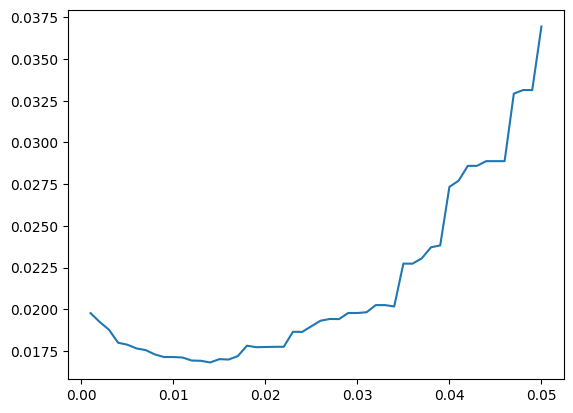

In [13]:
plt.plot(thresholds, best_scores)
plt.show()

In [14]:
print("BEST THRESHOLD:", thresholds[np.argmin(np.array(best_scores))])
print("ALPHA ON THIS THRESHOLD", best_alphas[np.argmin(np.array(best_scores))])

BEST THRESHOLD: 0.014
ALPHA ON THIS THRESHOLD 10.200000000000001


What we see? We see that if we reject all features with coefficients less than 0.014 we will have the best possible CV score on the original scaled data with ridge regression. Let's do it 

In [15]:
features2select = scaled_ridge_coefs[(scaled_ridge_coefs["coefficient"].abs() >= 0.014)].feature.values

selected_scaled_ridge_X = scaled_X[features2select]

print(selected_scaled_ridge_X.shape)

selected_scaled_ridge_reg = RidgeCV(alphas=[10.2]).fit(selected_scaled_ridge_X, scaled_y)
print("SCORE:", -selected_scaled_ridge_reg.best_score_)

(1459, 122)
SCORE: 0.016808295376507645


Our Leave-one-out CV score seems to be really better as before the feature selection (**0.0168082**)

### Residual Analysis

Now we have a dataset with selected informative features. Let's check how our residuals look like

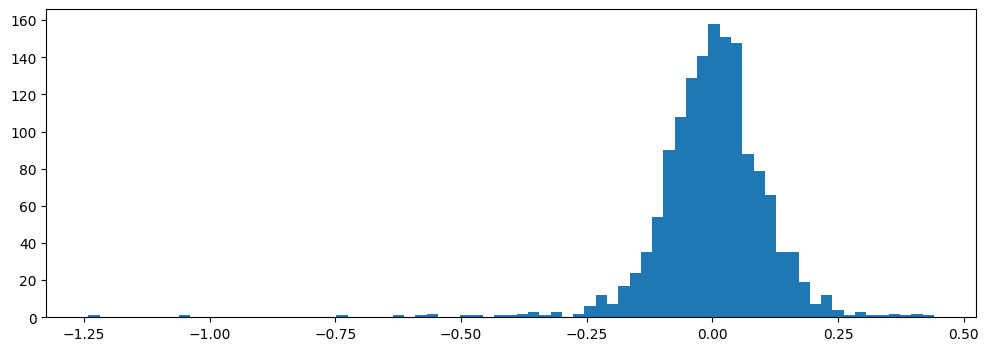

In [16]:
residuals = scaled_y - selected_scaled_ridge_reg.predict(selected_scaled_ridge_X)
residuals = pd.DataFrame({"residuals": residuals})
plt.figure(figsize=(12, 4))
plt.hist(residuals["residuals"], bins=75)
plt.show()

We can observe that some objects have obvious large residuals (absolute) with respect to the whole dataset. 

Let's delete all objects which have residuals bigger than 0.4 (absolute values)

In [17]:
residuals[(residuals["residuals"].abs() > 0.4)].shape[0]

13

There are only 13 objects with absolute residuals greater than 0.4. After the clearing we can once again check which alpha is the best for the cleared data

In [29]:
objects2clear_idx = selected_scaled_ridge_X[residuals["residuals"].abs() > 0.4].index

print("IDX OF OBJECTS TO DELETE:", objects2clear_idx)

final_scaled_ridge_X = selected_scaled_ridge_X.copy().drop(objects2clear_idx)
final_scaled_ridge_y = scaled_y.copy().drop(objects2clear_idx)

alphas = [i * 0.2 for i in range(1, 101)]

print(final_scaled_ridge_X.shape)

final_scaled_ridge_reg = RidgeCV(alphas=alphas).fit(final_scaled_ridge_X, final_scaled_ridge_y)

print("BEST ALPHA:", final_scaled_ridge_reg.alpha_)
print("BEST SCORE:", -final_scaled_ridge_reg.best_score_)

IDX OF OBJECTS TO DELETE: Index([30, 88, 328, 462, 495, 523, 632, 710, 916, 968, 970, 1298, 1324], dtype='int64')
(1446, 122)
BEST ALPHA: 6.2
BEST SCORE: 0.009633735707691032


What we see? We see that those 13 objects had pretty strong affect on our model because after their removing we received **0.00963** CV score on the remaining data. Generally we can say that 13 objects must not affect the whole picture of our dataset but from the other side they really spoil the linear picture in the data.

Let's check the new received residuals and try to visualize them

In [31]:
final_scaled_ridge_residuals = final_scaled_ridge_y - final_scaled_ridge_reg.predict(final_scaled_ridge_X)

First of all we can try to visualize the residuals with respect to our predicted values to check the homoscedasticity of our data at least visually

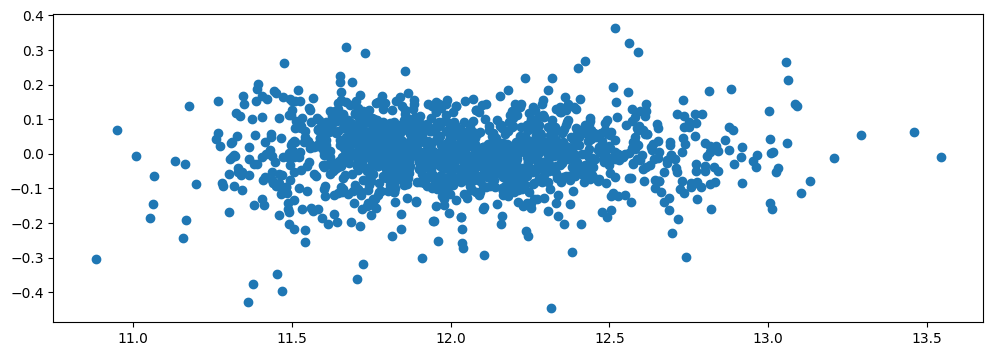

In [38]:
plt.figure(figsize=(12, 4))
plt.scatter(final_scaled_ridge_reg.predict(final_scaled_ridge_X), final_scaled_ridge_residuals)

From the scatter plot we can observe that we have no obvious heteroscedasticity in our data. 

Let's visualize our residuals in 3d with respect to some principal components

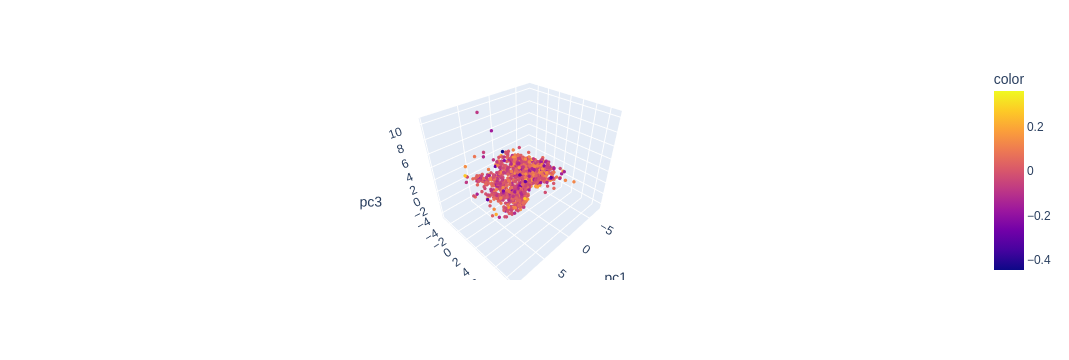

In [49]:
df2visualize = reduced.copy().drop(objects2clear_idx)

fig = px.scatter_3d(df2visualize, x="pc1", y="pc2", z="pc3", color=final_scaled_ridge_residuals)
fig.update_traces(marker_size = 2)
fig.show()

I've tried to visualize our residuals for several principal component but have noticed nothing obvious in terms of dependence from the principal component variables.

But it can be that we can try to make more sophisticated general prediction trying to predict the residuals with some model. (Try some kind of manual "boosting" rather than some built-in boosting in some library)

We will save residuals of the model which will give us the best submission result.

Let's finally try to submit the prediction of our Ridge regression after feature selection and outlier removing

In [59]:
scaled_ridge_sub_X = scaled_sub[features2select]

scaled_ridge_sub_prediction = np.exp(final_scaled_ridge_reg.predict(scaled_ridge_sub_X))

scaled_ridge_sub_df = pd.DataFrame({"Id": data_sub["Id"], "SalePrice": scaled_ridge_sub_prediction})
scaled_ridge_sub_df.to_csv("models/linear_models/scaled_ridge.csv", index=False)

## PCA decorrelating effect

PCA has a very usefull property. Features, created by PCA are uncorrelated. That means that we can use simple Linear Regression for our data and don't be afraid that we can receive some large model coefficients because of the multicollinearity problem. We can ensure in this by taking corr() method in our reduced data

<Axes: >

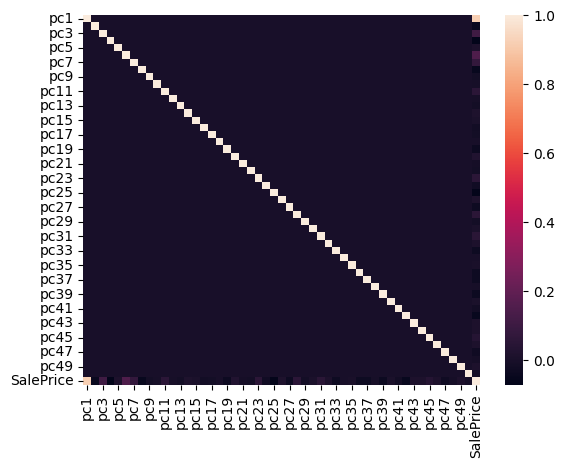

In [7]:
sns.heatmap(reduced.corr())

## Clearing objects with high residuals

As we said in the EDA we have some objects which look like outliers, but with respect to the hyperplane that we have not built yet.

Let's train Linear regression on the whole dataset and remove objects which give us to big residuals

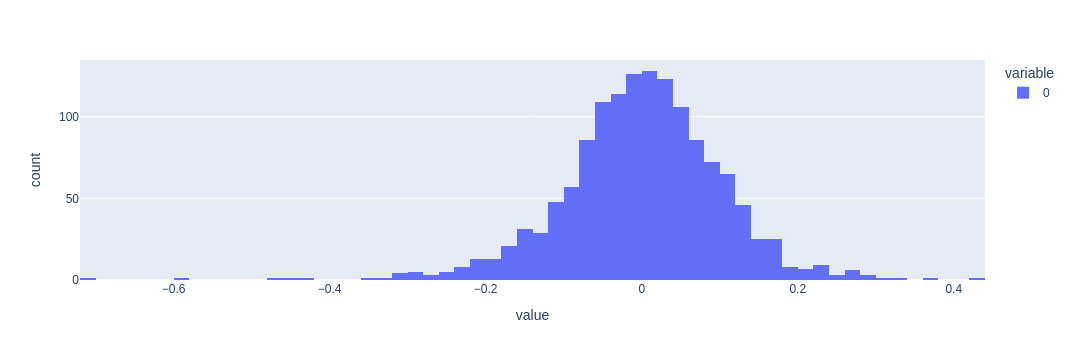

In [8]:
X = reduced.drop(["SalePrice"], axis=1).copy()
y = reduced["SalePrice"].copy()

reg = LinearRegression().fit(X, y)

pred = pd.Series(reg.predict(X))

residuals = y - pred

fig = px.histogram(residuals)
fig.show()

We see that we really have some objects which gives us abnormal residuals with respect to other data.

Also we can check new scatter 3D plot

Let's clear all objects where residuals are greater than 0.23 or smaller than -0.23

In [9]:
lin_cleared = cleared.copy()
lin_cleared = lin_cleared[(residuals <= 0.23) & (residuals >= -0.23)]
lin_deleted = cleared.copy()[(residuals > 0.23) | (residuals < -0.23)]

print("Count of deleted objects:", len(lin_deleted))

Count of deleted objects: 51


In [10]:
new_reduced = reduced.copy()[(residuals <= 0.23) & (residuals >= -0.23)]

## Scatter of cleared data

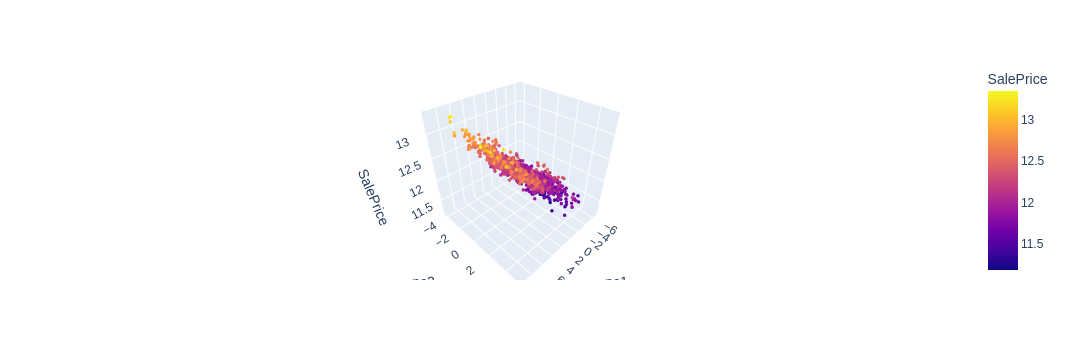

In [11]:
fig = px.scatter_3d(new_reduced, x="pc1", y="pc2", z="SalePrice", color="SalePrice")
fig.update_traces(marker_size = 2)
fig.show()

## Train/Test split and model applying

Let's take a look how Linear Regression performs on our cleared data

In [12]:
X = new_reduced.drop(["SalePrice"], axis=1).copy()
y = new_reduced["SalePrice"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

lr_reg = LinearRegression().fit(X_train, y_train)

real_y_train = np.exp(y_train)
real_y_test = np.exp(y_test)

train_pred = lr_reg.predict(X_train)
test_pred = lr_reg.predict(X_test)

print("TRAIN LOG RMSE:", root_mean_squared_error(y_train, train_pred))
print("TEST LOG RMSE:", root_mean_squared_error(y_test, test_pred))
print("." * 35)
print("TRAIN RMSE", root_mean_squared_error(real_y_train, np.exp(train_pred)))
print("TEST RMSE", root_mean_squared_error(real_y_test, np.exp(test_pred)))

TRAIN LOG RMSE: 0.08366991376522137
TEST LOG RMSE: 0.08990536148315299
...................................
TRAIN RMSE 15948.414021517825
TEST RMSE 18699.09895561385


We received much better results than using a baseline models. Let's try to make a submission

In [13]:
sub_reg = LinearRegression().fit(X, y)

pred = lr_reg.predict(X)
sub_pred = pd.Series(np.exp(sub_reg.predict(reduced_sub)))

sub_df = pd.DataFrame()
sub_df["Id"] = data_sub["Id"]
sub_df["SalePrice"] = sub_pred

sub_df.to_csv("models/PCA_linear_regression/submission.csv", index=False)

print("TRAIN LOG RMSE:", root_mean_squared_error(y, pred))

TRAIN LOG RMSE: 0.08495457280055252


These steps gave us even worse results on Kaggle than our baseline models &ndash; **0.14712**

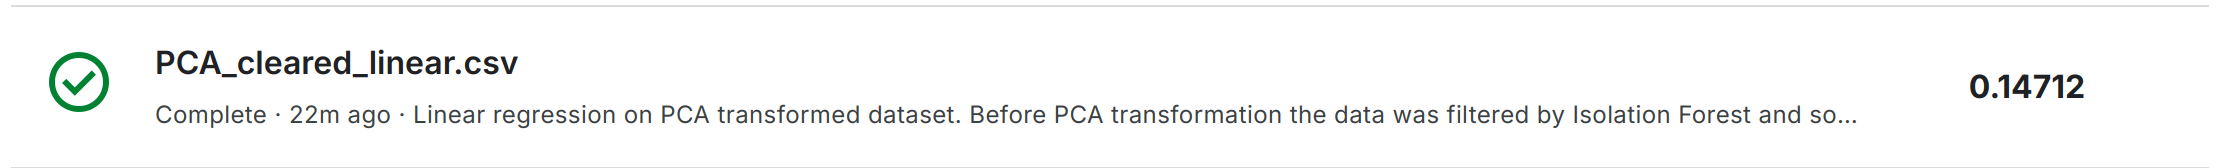

That means that we need to make some futher investigation in our data and the dependence between the features and the target isn't so easy and linear